# IS517 Final Project

This project aimed to help e-commerce businesses pinpoint the behaviors that signal high-intent customers, giving them actionable insights for targeted marketing

STEP 1: Loading Data

Dataset shape: (12330, 18)

Class distribution:
Revenue
False    10422
True      1908
Name: count, dtype: int64

Class proportion:
Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

STEP 2: Data Preprocessing

Categorical columns: ['Month', 'VisitorType']
Encoded Month: ['Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov', 'Oct', 'Sep']
Encoded VisitorType: ['New_Visitor', 'Other', 'Returning_Visitor']

STEP 3: Adding Feature Engineering
Created interaction features:
  - ProductDuration_PageValue
  - Admin_Bounce_Interaction
  - Exit_Bounce_Ratio

STEP 4: Train-Test Split
Training set size: (9864, 20)
Test set size: (2466, 20)
Training set class distribution:
Revenue
0    8338
1    1526
Name: count, dtype: int64

STEP 5: Handling Class Imbalance with SMOTE
Original training set: {0: 8338, 1: 1526}
Balanced training set: {0: 8338, 1: 8338}

STEP 6: Model Training and Evaluation

--- Logistic Regression ---

Classification Report:
    

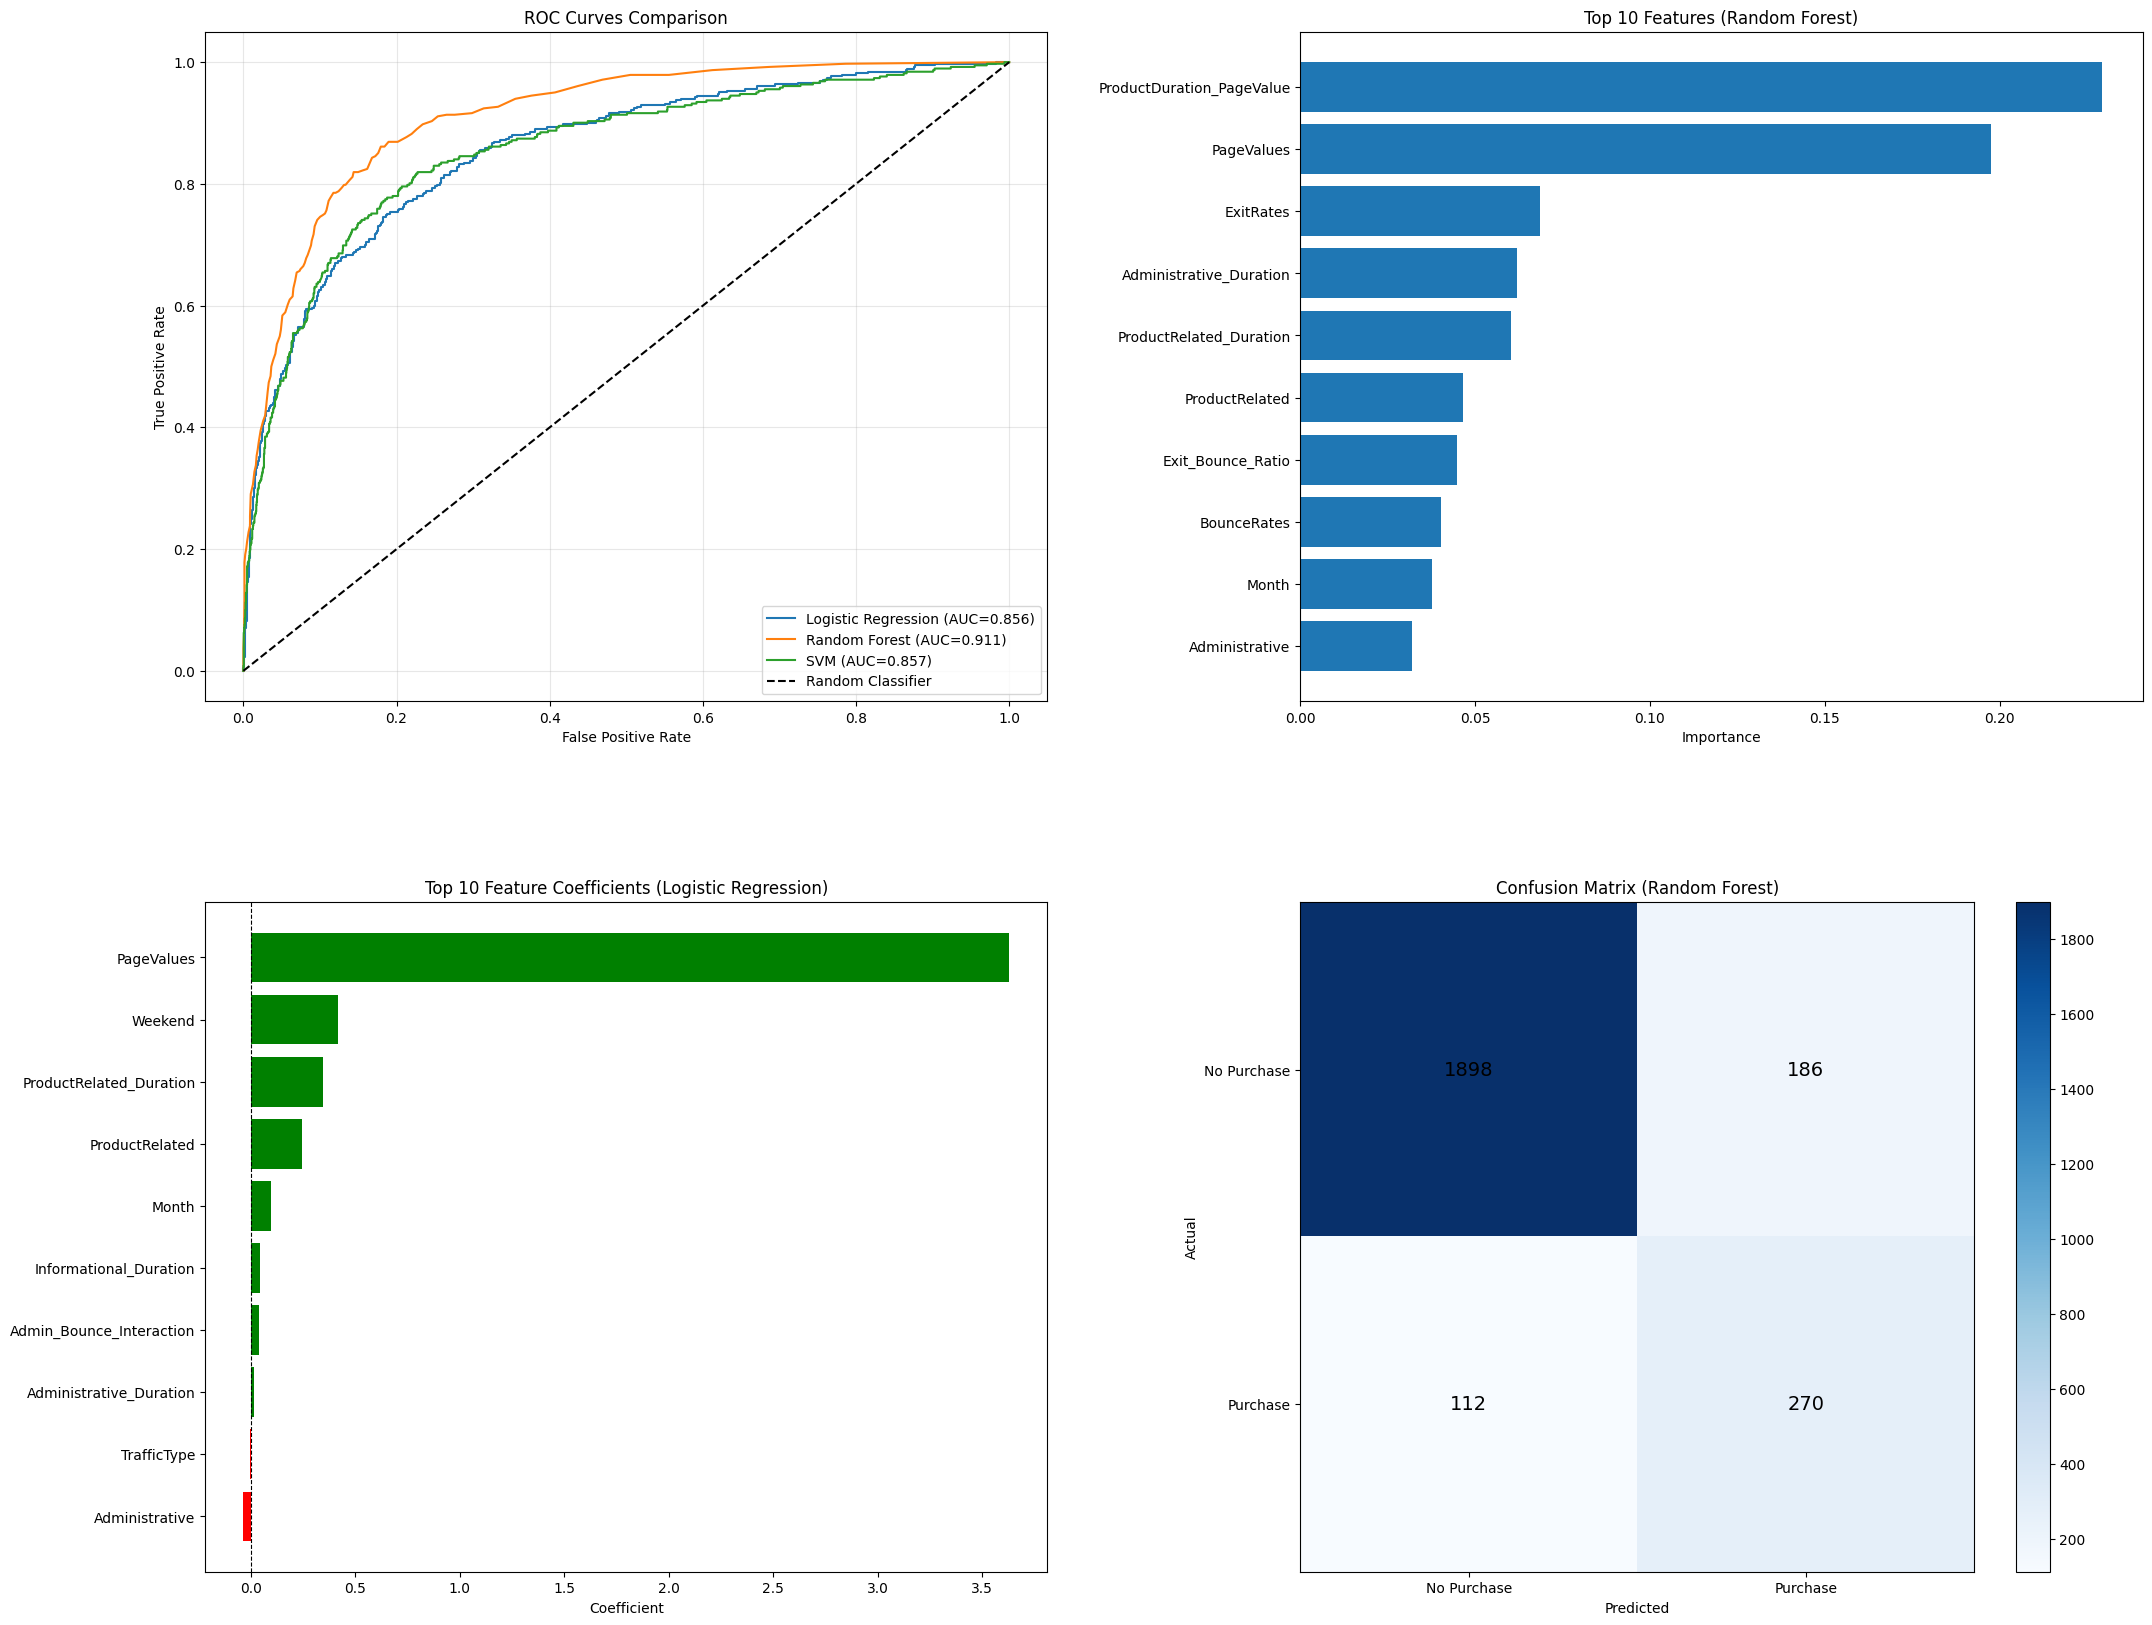

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. LOAD AND EXPLORE DATA
# ============================================
print("=" * 50)
print("STEP 1: Loading Data")
print("=" * 50)

# Load the dataset
df = pd.read_csv('online_shoppers_intention.csv')

print(f"\nDataset shape: {df.shape}")

print(f"\nClass distribution:")
print(df['Revenue'].value_counts())
print(f"\nClass proportion:")
print(df['Revenue'].value_counts(normalize=True))

# ============================================
# 2. DATA PREPROCESSING
# ============================================
print("\n" + "=" * 50)
print("STEP 2: Data Preprocessing")
print("=" * 50)

# Separate features and target
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"\nCategorical columns: {list(categorical_cols)}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {list(le.classes_)}")

# Convert boolean to integer
y = y.astype(int)


# ============================================
# 3. FEATURE ENGINEERING
# ============================================
print("\n" + "=" * 50)
print("STEP 3: Adding Feature Engineering")
print("=" * 50)

# Create interaction features as per research question 2
X['ProductDuration_PageValue'] = X['ProductRelated_Duration'] * X['PageValues']
X['Admin_Bounce_Interaction'] = X['Administrative_Duration'] * X['BounceRates']
X['Exit_Bounce_Ratio'] = X['ExitRates'] / (X['BounceRates'] + 0.001)  # Add small value to avoid division by zero

print("Created interaction features:")
print("  - ProductDuration_PageValue")
print("  - Admin_Bounce_Interaction")
print("  - Exit_Bounce_Ratio")

# ============================================
# 4. TRAIN-TEST SPLIT
# ============================================
print("\n" + "=" * 50)
print("STEP 4: Train-Test Split")
print("=" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts()}")

# ============================================
# 5. HANDLE CLASS IMBALANCE WITH SMOTE
# ============================================
print("\n" + "=" * 50)
print("STEP 5: Handling Class Imbalance with SMOTE")
print("=" * 50)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {y_train.value_counts().to_dict()}")
print(f"Balanced training set: {pd.Series(y_train_balanced).value_counts().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# ============================================
# 6. MODEL TRAINING AND EVALUATION
# ============================================
print("\n" + "=" * 50)
print("STEP 6: Model Training and Evaluation")
print("=" * 50)

# Dictionary to store results
results = {}

# ----------------
# Logistic Regression
# ----------------
print("\n--- Logistic Regression ---")
lr_model = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_balanced)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

results['Logistic Regression'] = {
    'predictions': y_pred_lr,
    'probabilities': y_pred_proba_lr,
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lr)
}

# ----------------
# Random Forest
# ----------------
print("\n--- Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

results['Random Forest'] = {
    'predictions': y_pred_rf,
    'probabilities': y_pred_proba_rf,
    'roc_auc': roc_auc_score(y_test, y_pred_proba_rf)
}

# ----------------
# Support Vector Machine
# ----------------
print("\n--- Support Vector Machine ---")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train_balanced)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_svm):.4f}")

results['SVM'] = {
    'predictions': y_pred_svm,
    'probabilities': y_pred_proba_svm,
    'roc_auc': roc_auc_score(y_test, y_pred_proba_svm)
}

# ============================================
# 7. FEATURE IMPORTANCE ANALYSIS
# ============================================
print("\n" + "=" * 50)
print("STEP 7: Feature Importance Analysis")
print("=" * 50)

# Logistic Regression Coefficients
print("\n--- Logistic Regression Feature Coefficients (Top 10) ---")
feature_names = X.columns
lr_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print(lr_coef.head(10))

# Random Forest Feature Importance
print("\n--- Random Forest Feature Importance (Top 10) ---")
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(rf_importance.head(10))

# ============================================
# 8. VISUALIZATIONS
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(25, 20))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# ROC Curves
ax = axes[0, 0]
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    ax.plot(fpr, tpr, label=f"{model_name} (AUC={result['roc_auc']:.3f})")
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Feature Importance (Random Forest)
ax = axes[0, 1]
top_features = rf_importance.head(10)
ax.barh(top_features['Feature'], top_features['Importance'])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features (Random Forest)')
ax.invert_yaxis()

# Logistic Regression Coefficients
ax = axes[1, 0]
top_coef = lr_coef.head(10)
colors = ['green' if x > 0 else 'red' for x in top_coef['Coefficient']]
ax.barh(top_coef['Feature'], top_coef['Coefficient'], color=colors)
ax.set_xlabel('Coefficient')
ax.set_title('Top 10 Feature Coefficients (Logistic Regression)')
ax.invert_yaxis()
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Confusion Matrix (Random Forest - Best Model)
ax = axes[1, 1]
cm = confusion_matrix(y_test, y_pred_rf)

# Display the matrix as an image
im = ax.imshow(cm, cmap='Blues', aspect='auto')

# Add text annotations (the numbers)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black", fontsize=14)

# Labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Random Forest)')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No Purchase', 'Purchase'])
ax.set_yticklabels(['No Purchase', 'Purchase'])

# Add colorbar
plt.colorbar(im, ax=ax)

# ============================================
# 9. HYPOTHESIS TESTING
# ============================================
print("\n" + "=" * 50)
print("STEP 8: Testing Hypotheses")
print("=" * 50)

# Hypothesis 3: Returning visitors convert at higher rates
visitor_type_col = 'VisitorType'
if visitor_type_col in df.columns:
    visitor_conversion = df.groupby(visitor_type_col)['Revenue'].mean()
    print(f"\nHypothesis 3: Conversion rates by visitor type")
    print(visitor_conversion)

# Hypothesis 4: Longer Product-Related Duration positively associated with purchase
correlation = df['ProductRelated_Duration'].corr(df['Revenue'])
print(f"\nHypothesis 4: Correlation between Product Duration and Revenue: {correlation:.4f}")

# ============================================
# 10. SUMMARY
# ============================================
print("\n" + "=" * 50)
print("SUMMARY")
print("=" * 50)

print("\nModel Performance (ROC-AUC):")
for model_name, result in results.items():
    print(f"  {model_name}: {result['roc_auc']:.4f}")


